# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

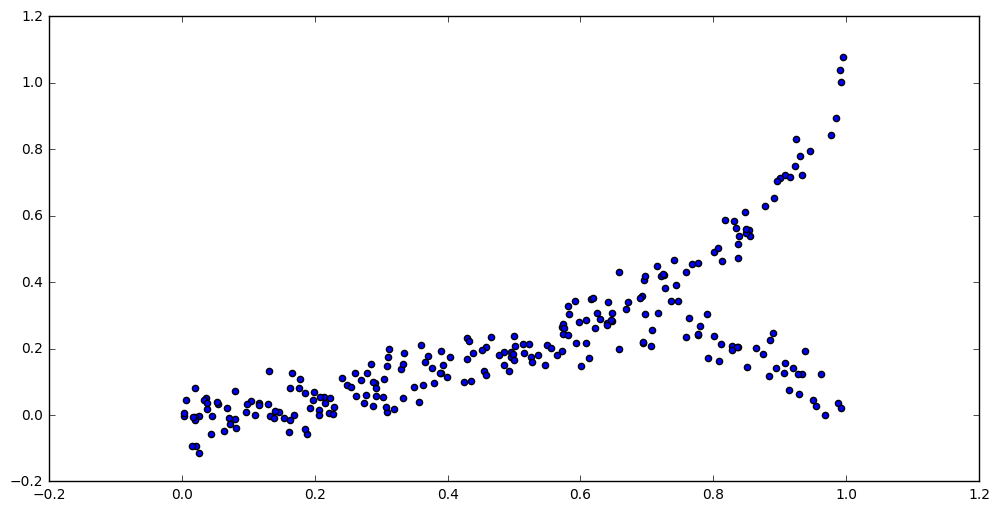

In [3]:
plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, variance=0.01, prior_Z='DP')
m.log_likelihood()

1164.0566574255474

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

phi:  (250, 2)


IndexError: too many indices for array

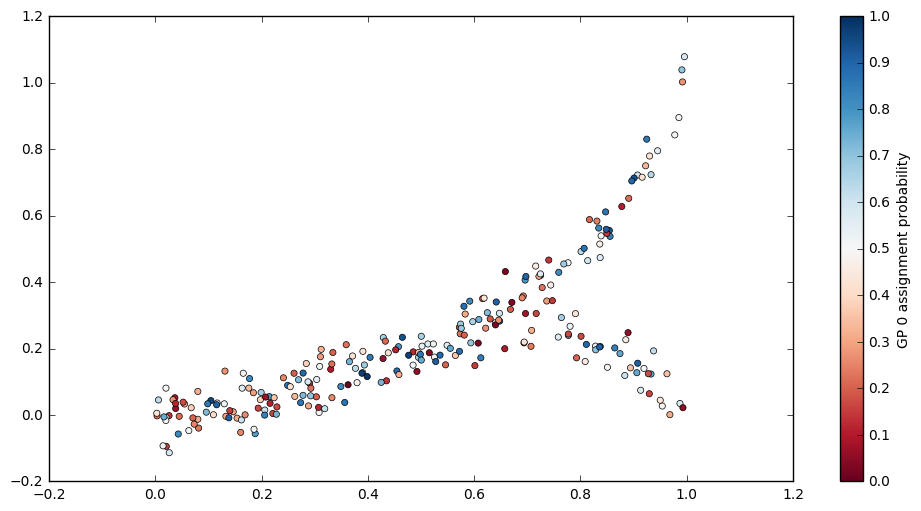

In [5]:
from plotter import OMGPplot
OMGPplot(m,X,Y)

In [6]:
debug

> /Users/james/anaconda/envs/py35-tf10/lib/python3.5/site-packages/tensorflow/python/util/compat.py(45)as_bytes()
     43   else:
     44     raise TypeError('Expected binary or unicode string, got %r' %
---> 45                     (bytes_or_text,))
     46 
     47 

ipdb> q


There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

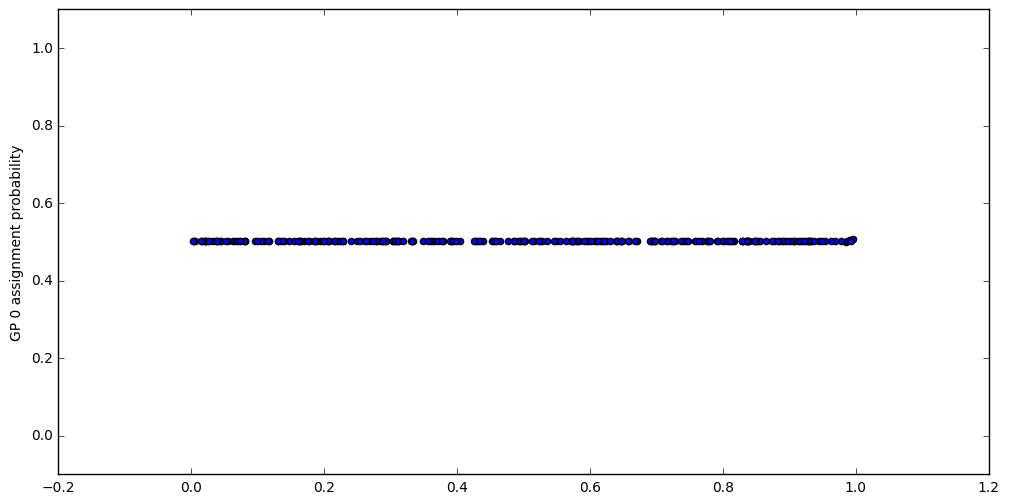

In [7]:
from plotter import OMGPplot_probs
OMGPplot_probs(m, X, gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [6]:
m.optimize(step_length=0.01)

iteration 1 bound=1144.06227579 grad=450.35601406, beta=0
iteration 2 bound=1152.62286266 grad=398.606179366, beta=1.01505939755
iteration 3 bound=1164.57370043 grad=330.05532339, beta=1.02032564508
iteration 4 bound=1178.58651799 grad=262.200657608, beta=0.997037210246
iteration 5 bound=1192.03938945 grad=197.936782088, beta=0.932580497784
iteration 6 bound=1202.43974373 grad=141.705981482, beta=0.848576972234
iteration 7 bound=1209.48473779 grad=99.8384167572, beta=0.784869475471
iteration 8 bound=1214.08326937 grad=72.1060278659, beta=0.75015903754
iteration 9 bound=1217.09111363 grad=54.4208412484, beta=0.727376346858
iteration 10 bound=1219.11599777 grad=43.1798785368, beta=0.711336418846
iteration 11 bound=1220.58506063 grad=35.7350510987, beta=0.722105143314
iteration 12 bound=1221.76497914 grad=30.257254507, beta=0.766876161017
iteration 13 bound=1222.7842222 grad=25.69588088, beta=0.814449117573
iteration 14 bound=1223.69177019 grad=21.6092648742, beta=0.845694713732
iteration

TypeError: Expected binary or unicode string, got <GPflow.param.DataHolder object at 0x11e5803c8>

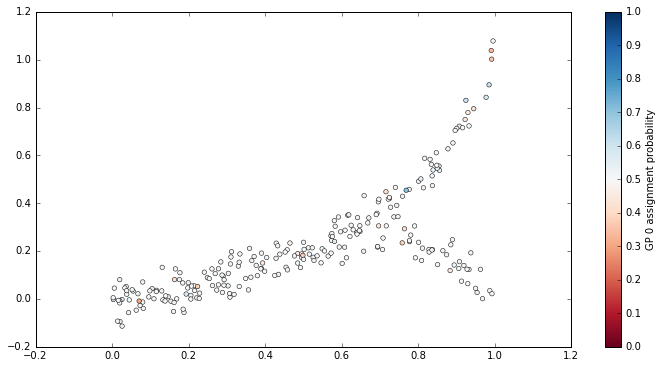

In [9]:
OMGPplot(m,X,Y)

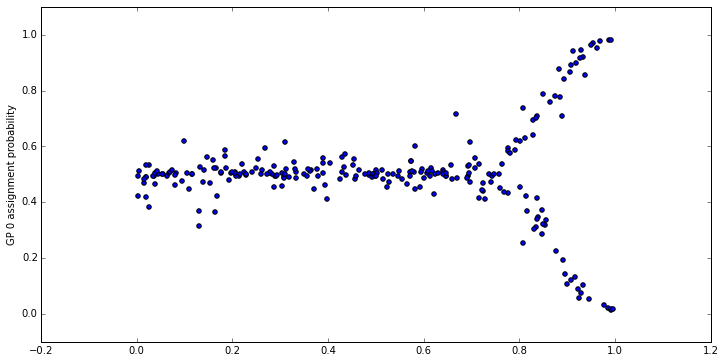

In [15]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [16]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.01,+ve,,
rbf_1.variance,1.0,+ve,,
rbf_1.lengthscale,1.0,+ve,,
rbf.variance,1.0,+ve,,
rbf.lengthscale,1.0,+ve,,


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [17]:
m.optimize(step_length=0.01, maxiter=200)

iteration 200 bound=1588.80940759 grad=197.3883808, beta=0.0 maxiter exceeded


 :0: FutureWarning:IPython widgets are experimental and may change in the future.


In [18]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.0014606243382,+ve,,
rbf_1.variance,1.02213521375,+ve,,
rbf_1.lengthscale,0.595341949099,+ve,,
rbf.variance,1.16851232834,+ve,,
rbf.lengthscale,0.448887117217,+ve,,


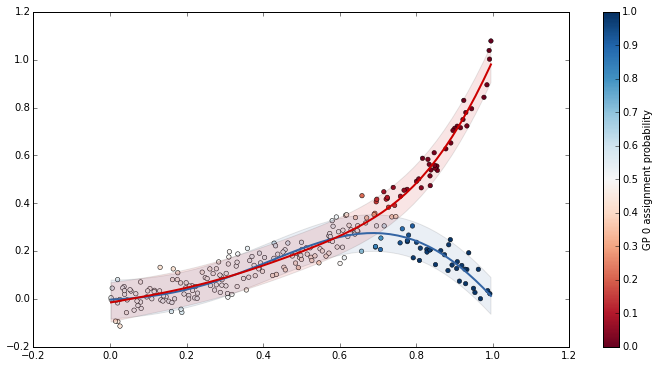

In [19]:
OMGPplot(m,X,Y)

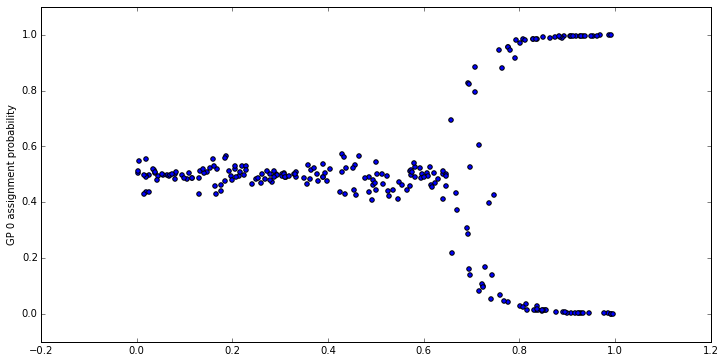

In [20]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [21]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

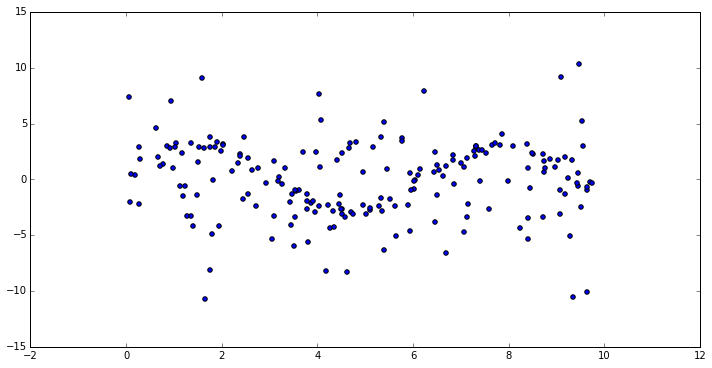

In [23]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [24]:
kernels = [GPy.kern.RBF(1)]
m = OMGP(x, y, K=1, prior_Z='DP', kernels=kernels)
m.variance = 3
m.hyperparam_interval = 100
m.rbf.lengthscale = 2

In [25]:
m.optimize(verbose=False)

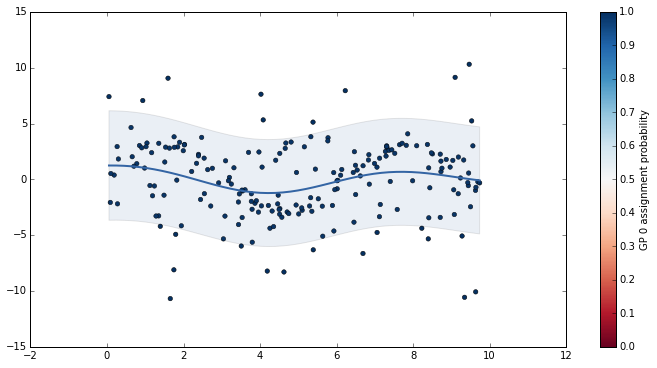

In [27]:
OMGPplot(m,x)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [28]:
kernels = [GPy.kern.White(1, name='Noise'), GPy.kern.RBF(1, name='Signal')]
m = OMGP(x, y, K=2, prior_Z='DP', kernels=kernels)
m.variance = 3
m.hyperparam_interval = 250
m.Signal.lengthscale = 2

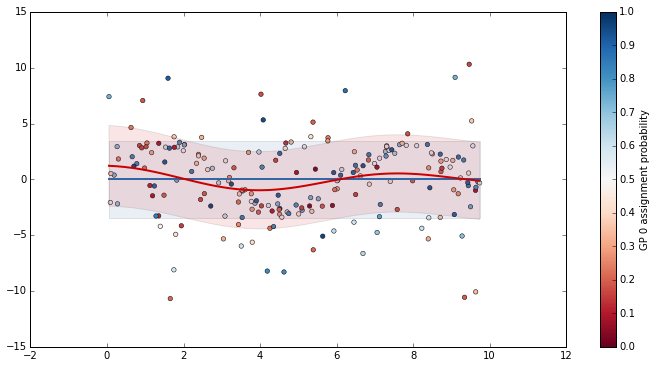

In [29]:
OMGPplot(m,x)

In [30]:
m.optimize(step_length=0.01, verbose=False)

In [31]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.322524350505,+ve,,
Noise.variance,8.84138047261,+ve,,
Signal.variance,3.02502159938,+ve,,
Signal.lengthscale,1.50887475231,+ve,,


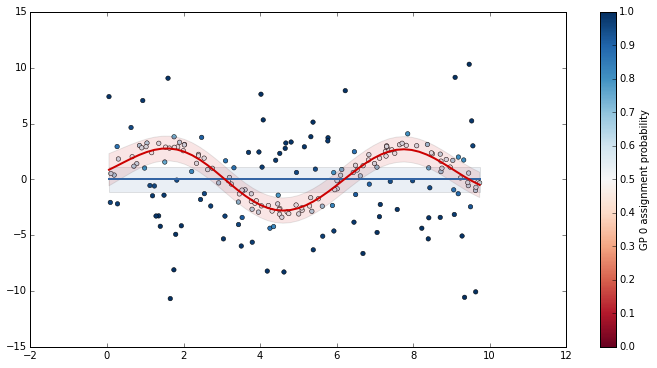

In [32]:
OMGPplot(m,x)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

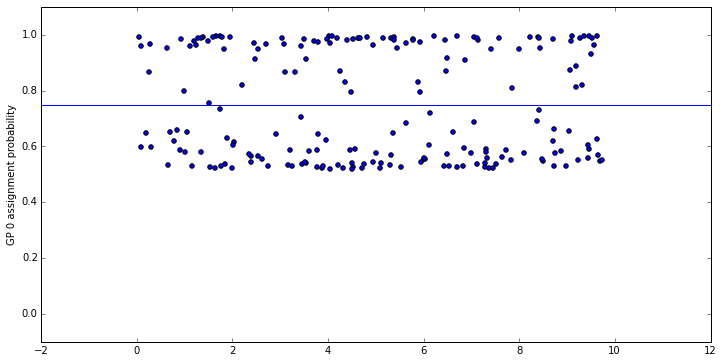

In [34]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [36]:
thr = 0.75
idx = np.where(m.phi[:,0] < thr)[0]
nidx = np.where(m.phi[:,0] >= thr)[0]

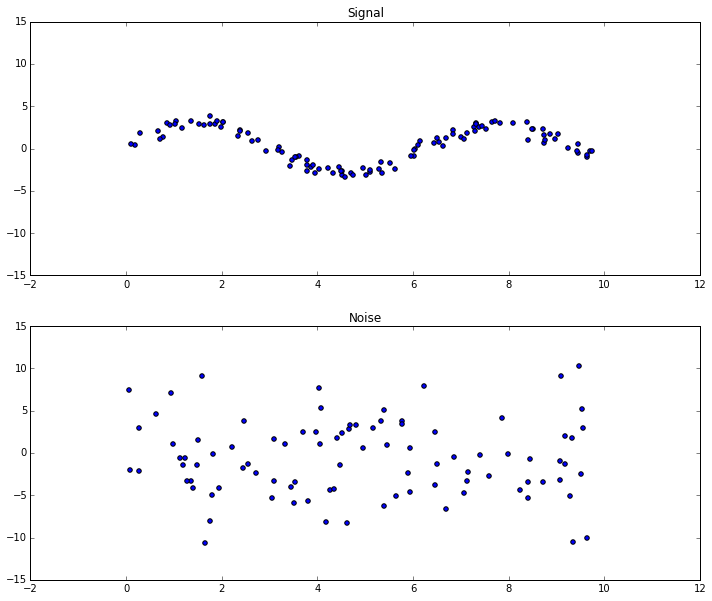

In [37]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');